# Floodplain Mapping via RasProcess CLI (Recommended for Windows)

This notebook demonstrates floodplain mapping using **RasProcess.exe**, the fastest and most reliable method for Windows users.

## When to Use This Method

✅ **Best for:**
- Windows environments
- Batch processing multiple plans
- Production workflows requiring speed
- All map variables (WSE, Depth, Velocity, Froude, Shear, D*V, D*V²)
- Time-series analysis (specific timesteps)

❌ **Not suitable for:**
- Cloud/Docker environments (requires HEC-RAS installation)
- Linux/Mac environments (Windows-only)

## Comparison with Other Methods

| Method | Speed | Reliability | Matches HEC-RAS to 0.01' | Cloud-Compatible | GUI Required | Variables |
|--------|-------|-------------|--------------------------|------------------|--------------|-----------|
| **15_b: RasProcess CLI** | ⭐⭐⭐ Fastest (8-10 sec) | ⭐⭐⭐ Excellent | ✅ Yes (100% - native) | ❌ No | ❌ No | All |
| 15_c: Python-GIS | ⭐⭐ Moderate (15-20 sec) | ⭐⭐⭐ Excellent | ✅ Yes (horizontal)* | ✅ Yes | ❌ No | WSE, Depth, Velocity (2D only) |
| 15_a: GUI Automation | ⭐ Slow (60+ sec) | ⭐ Fragile | ✅ Yes (100% - native) | ❌ No | ✅ Yes | All |

\* Python-GIS matches HEC-RAS to 0.01' for **2D horizontal interpolation only** (validation tests in notebook 15_c). Limitations: 2D mesh only (no 1D support yet), horizontal interpolation only.

**Recommendation**: Use this method (15_b) for Windows-based workflows.

## Prerequisites

- HEC-RAS 6.x installed (provides RasProcess.exe)
- Windows operating system
- Computed HEC-RAS plan with HDF results
- rasterio (optional, for georeferencing fix)

In [ ]:
#!pip install --upgrade ras-commander

# Upgrade RAS-Commander to 0.87.3 minimum

In [ ]:
# =============================================================================
# DEVELOPMENT MODE TOGGLE
# =============================================================================
USE_LOCAL_SOURCE = False  # <-- TOGGLE THIS

if USE_LOCAL_SOURCE:
    import sys
    from pathlib import Path
    local_path = str(Path.cwd().parent)
    if local_path not in sys.path:
        sys.path.insert(0, local_path)
    print(f"📁 LOCAL SOURCE MODE: Loading from {local_path}/ras_commander")
else:
    print("📦 PIP PACKAGE MODE: Loading installed ras-commander")

# Import ras-commander
from ras_commander import *

# Verify which version loaded
import ras_commander
print(f"✓ Loaded: {ras_commander.__file__}")

In [4]:
# Additional imports for visualization
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np

## Step 1: Initialize Project

We'll use the BaldEagleCrkMulti2D example project.

In [5]:
# Extract example project
project_path = RasExamples.extract_project("BaldEagleCrkMulti2D", suffix="15b")

# Initialize project
init_ras_project(project_path, "6.6")

print(f"Project: {ras.project_name}")
print(f"Folder: {ras.project_folder}")

2025-12-13 12:02:01 - ras_commander.RasExamples - INFO - Found zip file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\Example_Projects_6_6.zip
2025-12-13 12:02:01 - ras_commander.RasExamples - INFO - Loading project data from CSV...
2025-12-13 12:02:01 - ras_commander.RasExamples - INFO - Loaded 68 projects from CSV.
2025-12-13 12:02:01 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----
2025-12-13 12:02:01 - ras_commander.RasExamples - INFO - Extracting project 'BaldEagleCrkMulti2D'
2025-12-13 12:02:01 - ras_commander.RasExamples - INFO - Project 'BaldEagleCrkMulti2D' already exists. Deleting existing folder...
2025-12-13 12:02:14 - ras_commander.RasExamples - INFO - Existing folder for project 'BaldEagleCrkMulti2D' has been deleted.
2025-12-13 12:02:16 - ras_commander.RasExamples - INFO - Successfully extracted project 'BaldEagleCrkMulti2D' to C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\examp

Project: BaldEagleDamBrk
Folder: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D


## Step 2: Pre-requisite - Check .rasmap Compatibility

**IMPORTANT**: For HEC-RAS 5.0.7 projects running in 6.x, the `.rasmap` file must be upgraded to 6.x format before stored map generation will work.

The `ensure_rasmap_compatible()` function automatically detects and upgrades old `.rasmap` files.

In [6]:
# Check .rasmap compatibility (upgrade if needed)
result = RasMap.ensure_rasmap_compatible(auto_upgrade=True)

print(f"Status: {result['status']}")
print(f"Message: {result['message']}")
print(f"Version: {result['version']}")

if result['status'] == 'manual_needed':
    print("\n⚠️ Manual intervention required:")
    print("1. Open project in HEC-RAS")
    print("2. Click 'GIS Tools' > 'RAS Mapper'")
    print("3. Wait for RASMapper to open (this upgrades .rasmap)")
    print("4. Close RASMapper and HEC-RAS")
    print("5. Re-run this notebook")
else:
    print("\n✅ .rasmap file is ready for stored map generation")

2025-12-13 12:02:16 - ras_commander.RasMap - INFO - .rasmap file is already compatible (version 2.0.0)


Status: ready
Message: Already compatible (version 2.0.0)
Version: 2.0.0

✅ .rasmap file is ready for stored map generation


## Step 3: Compute Plan (if needed)

Make sure plan 06 has been computed.

In [7]:
# Check if plan 06 has HDF results
hdf_path = ras.project_folder / f"{ras.project_name}.p06.hdf"

if not hdf_path.exists():
    print("Computing plan 06...")
    RasCmdr.compute_plan("06")
else:
    print("Plan 06 already computed")

2025-12-13 12:02:16 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D
2025-12-13 12:02:16 - ras_commander.RasCmdr - INFO - Running HEC-RAS from the Command Line:
2025-12-13 12:02:16 - ras_commander.RasCmdr - INFO - Running command: "C:\Program Files (x86)\HEC\HEC-RAS\6.6\Ras.exe" -c "C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.prj" "C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06"


Computing plan 06...


2025-12-13 12:06:46 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 06
2025-12-13 12:06:46 - ras_commander.RasCmdr - INFO - Total run time for plan 06: 270.18 seconds


## Step 4: Generate Floodplain Maps

### Available Map Types

| Parameter | Map Type | Description |
|-----------|----------|-------------|
| `wse` | Water Surface Elevation | Maximum WSE |
| `depth` | Water Depth | Maximum depth |
| `velocity` | Velocity Magnitude | Maximum velocity |
| `froude` | Froude Number | Flow regime indicator |
| `shear_stress` | Shear Stress | Bed shear stress |
| `depth_x_velocity` | D*V | Hazard metric |
| `depth_x_velocity_sq` | D*V² | Impact metric |

In [8]:
#!pip install --upgrade ras-commander

In [11]:
# Generate WSE, Depth, Velocity maps for plan 06
print("Generating stored maps for Plan 06...")
print("This may take 1-2 minutes.\n")

results = RasProcess.store_maps(
    plan_number="06",
    profile="Max",
    wse=True,
    depth=True,
    depth_x_velocity=True,
    velocity=True,
    fix_georef=True,
    ras_version="6.6"
)

print("\nGenerated files:")
for map_type, files in results.items():
    print(f"  {map_type}: {len(files)} file(s)")
    for f in files:
        print(f"    - {f.name}")

2025-12-13 12:22:40 - ras_commander.RasProcess - INFO - Created plan layer 'Grid Precip Infiltration' in rasmap for BaldEagleDamBrk.p06.hdf
2025-12-13 12:22:40 - ras_commander.RasProcess - INFO - Running StoreAllMaps for plan 06...


Generating stored maps for Plan 06...
This may take 1-2 minutes.



2025-12-13 12:24:27 - ras_commander.RasProcess - WARNING - StoreAllMaps stderr: Warning 1: TIFFFetchNormalTag:ASCII value for tag "GDALNoDataValue" contains null byte in value; value incorrectly truncated during reading due to implementation limitations
Warning 1: TIFFFetchNormalTag:ASCII value for tag "GDALNoDataValue" contains null byte in value; value incorrectly truncated during reading due to implementation limitations
Warning 1: TIFFFetchNormalTag:ASCII value for tag "GDALNoDataValue" contains null byte in value; value incorrectly truncated during reading due to implementation limitations
Warning 1: TIFFFetchNormalTag:ASCII value for tag "GDALNoDataValue" contains null byte in value; value incorrectly truncated during reading due to implementation limitations

2025-12-13 12:24:27 - ras_commander.RasProcess - INFO - Generated 1 wse TIF(s)
2025-12-13 12:24:27 - ras_commander.RasProcess - INFO - Generated 1 depth TIF(s)
2025-12-13 12:24:27 - ras_commander.RasProcess - INFO - Generat


Generated files:
  wse: 1 file(s)
    - WSE (Max).Terrain50.dtm_20ft.tif
  depth: 1 file(s)
    - Depth (Max).Terrain50.dtm_20ft.tif
  velocity: 1 file(s)
    - Velocity (Max).Terrain50.dtm_20ft.tif
  depth_x_velocity: 1 file(s)
    - D _ V (Max).Terrain50.dtm_20ft.tif


## Step 5: Generate Additional Variables

RasProcess supports all HEC-RAS output variables.

In [13]:
# Generate Froude and D*V hazard maps
results_extra = RasProcess.store_maps(
    plan_number="06",
    profile="Max",
    wse=False,
    depth=False,
    velocity=False,
    froude=True,
    depth_x_velocity=True,
    fix_georef=True,
    ras_version="6.6"
)

print("Generated additional maps:")
for map_type, files in results_extra.items():
    for f in files:
        print(f"  - {f.name}")

2025-12-13 12:30:23 - ras_commander.RasProcess - INFO - Created plan layer 'Grid Precip Infiltration' in rasmap for BaldEagleDamBrk.p06.hdf
2025-12-13 12:30:23 - ras_commander.RasProcess - INFO - Running StoreAllMaps for plan 06...
2025-12-13 12:33:48 - ras_commander.RasProcess - WARNING - StoreAllMaps stderr: Warning 1: TIFFFetchNormalTag:ASCII value for tag "GDALNoDataValue" contains null byte in value; value incorrectly truncated during reading due to implementation limitations
Warning 1: TIFFFetchNormalTag:ASCII value for tag "GDALNoDataValue" contains null byte in value; value incorrectly truncated during reading due to implementation limitations

2025-12-13 12:33:48 - ras_commander.RasProcess - INFO - Generated 1 froude TIF(s)
2025-12-13 12:33:48 - ras_commander.RasProcess - INFO - Generated 1 depth_x_velocity TIF(s)
2025-12-13 12:33:48 - ras_commander.RasProcess - INFO - Fixed georeferencing: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_pr

Generated additional maps:
  - Froude (Max).Terrain50.dtm_20ft.tif
  - D _ V (Max).Terrain50.dtm_20ft.tif


## Step 6: Time-Series Maps

Generate maps for specific timesteps instead of Max/Min.

In [14]:
# Get available timestamps
timestamps = RasProcess.get_plan_timestamps("06")

print(f"Available timestamps: {len(timestamps)} total")
print(f"  First: {timestamps[0]}")
print(f"  Last:  {timestamps[-1]}")

# Generate map for specific timestep
if len(timestamps) > 10:
    target_ts = timestamps[10]
    print(f"\nGenerating WSE for timestep: {target_ts}")
    
    results_ts = RasProcess.store_maps(
        plan_number="06",
        profile=target_ts,
        wse=True,
        depth=False,
        velocity=False,
        fix_georef=True,
        ras_version="6.6"
    )
    
    for f in results_ts['wse']:
        print(f"  Generated: {f.name}")

2025-12-13 12:33:49 - ras_commander.hdf.HdfPlan - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-12-13 12:33:49 - ras_commander.hdf.HdfPlan - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-12-13 12:33:49 - ras_commander.hdf.HdfPlan - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-12-13 12:33:49 - ras_commander.hdf.HdfPlan - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-12-13 12:33:49 - ras_commander.RasProcess - INFO - Created plan layer 'Grid Precip Infi

Available timestamps: 721 total
  First: 09SEP2018 00:00:00
  Last:  14SEP2018 00:00:00

Generating WSE for timestep: 09SEP2018 01:40:00


2025-12-13 12:33:52 - ras_commander.RasProcess - WARNING - StoreAllMaps stderr: Warning 1: TIFFFetchNormalTag:ASCII value for tag "GDALNoDataValue" contains null byte in value; value incorrectly truncated during reading due to implementation limitations

2025-12-13 12:33:52 - ras_commander.RasProcess - INFO - Generated 1 wse TIF(s)
2025-12-13 12:33:53 - ras_commander.RasProcess - INFO - Fixed georeferencing: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D\Grid Precip Infiltration\WSE (09SEP2018 01 40 00).Terrain50.dtm_20ft.tif


  Generated: WSE (09SEP2018 01 40 00).Terrain50.dtm_20ft.tif


## Step 7: Visualize Results

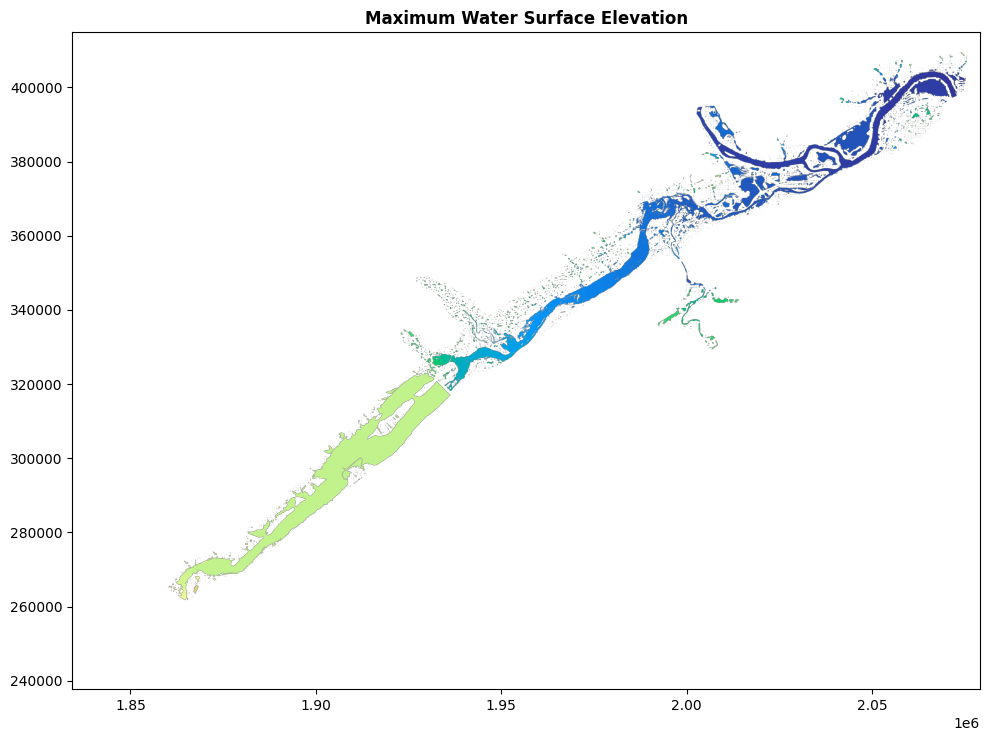

CRS: EPSG:2271
Resolution: (36.504512049933, 36.504512049933)
Bounds: BoundingBox(left=1834327.1955903, bottom=237753.0548772926, right=2079089.948885101, top=414872.9473435675)


In [15]:
# Plot WSE map
if 'wse' in results and results['wse']:
    with rasterio.open(results['wse'][0]) as src:
        fig, ax = plt.subplots(figsize=(10, 8))
        show(src, ax=ax, cmap='terrain', title='Maximum Water Surface Elevation')
        plt.tight_layout()
        plt.show()
        
        print(f"CRS: {src.crs}")
        print(f"Resolution: {src.res}")
        print(f"Bounds: {src.bounds}")

## Step 8: Batch Processing

Generate maps for all plans with HDF results.

In [16]:
# Generate maps for all plans
all_results = RasProcess.store_all_maps(
    profile="Max",
    wse=True,
    depth=True,
    velocity=True,
    fix_georef=True,
    ras_version="6.6"
)

print("\nBatch Processing Results:")
print("=" * 60)
for plan_num, files in all_results.items():
    if 'error' in files:
        print(f"Plan {plan_num}: ERROR - {files['error']}")
    else:
        total = sum(len(f) for f in files.values())
        print(f"Plan {plan_num}: {total} files generated")

2025-12-13 12:33:57 - ras_commander.RasProcess - INFO - Created plan layer 'Grid Precip Infiltration' in rasmap for BaldEagleDamBrk.p06.hdf
2025-12-13 12:33:57 - ras_commander.RasProcess - INFO - Running StoreAllMaps for plan 06...
2025-12-13 12:34:06 - ras_commander.RasProcess - WARNING - StoreAllMaps stderr: Warning 1: TIFFFetchNormalTag:ASCII value for tag "GDALNoDataValue" contains null byte in value; value incorrectly truncated during reading due to implementation limitations
Warning 1: TIFFFetchNormalTag:ASCII value for tag "GDALNoDataValue" contains null byte in value; value incorrectly truncated during reading due to implementation limitations
Warning 1: TIFFFetchNormalTag:ASCII value for tag "GDALNoDataValue" contains null byte in value; value incorrectly truncated during reading due to implementation limitations

2025-12-13 12:34:06 - ras_commander.RasProcess - INFO - Generated 1 wse TIF(s)
2025-12-13 12:34:06 - ras_commander.RasProcess - INFO - Generated 1 depth TIF(s)
2025-


Batch Processing Results:
Plan 06: 3 files generated


## Technical Explanation: How RasProcess Works

### RasProcess.exe CLI Tool

RasProcess.exe is an **undocumented command-line utility** bundled with HEC-RAS 6.x that enables headless map generation without opening the RASMapper GUI.

**Location**: `C:\Program Files (x86)\HEC\HEC-RAS\6.6\RasProcess.exe`

### Workflow

1. **Modify .rasmap XML**: Add `<Layer>` elements for desired map types
   ```xml
   <Layer Name="WSE" Type="RASResultsMap" Filename=".\Results\WSE (Max).vrt">
     <MapParameters MapType="elevation" ProfileName="Max"/>
   </Layer>
   ```

2. **Execute RasProcess.exe**: Run subprocess with XML command
   ```bash
   RasProcess.exe -Command=StoreAllMaps \
                  -RasMapFilename=project.rasmap \
                  -ResultFilename=project.p06.hdf
   ```

3. **Parse Output**: Scan folder for generated .tif files

4. **Fix Georeferencing**: Apply CRS from project projection file
   - HEC-RAS outputs TIFs without proper CRS metadata
   - `fix_georef=True` uses rasterio to add CRS

5. **Restore .rasmap**: Replace modified .rasmap with backup

### Performance

RasProcess is the **fastest method** because:
- Uses HEC-RAS native rasterization engine (same as RASMapper)
- No GUI overhead
- Optimized C++ code
- Parallel processing within HEC-RAS

**Typical performance** (BaldEagleCrkMulti2D, 3 variables):
- RasProcess CLI: 8-10 seconds
- Python-GIS: 15-20 seconds  
- GUI Automation: 60+ seconds

## Troubleshooting

### Issue: RasProcess.exe not found
**Solution**: Ensure HEC-RAS 6.x is installed. Check path manually:
```python
rasprocess_path = RasProcess.find_rasprocess("6.6")
print(rasprocess_path)
```

### Issue: No maps generated
**Solution**: 
1. Check .rasmap upgrade: `RasMap.ensure_rasmap_compatible()`
2. Verify HDF exists: `(ras.project_folder / f"{ras.project_name}.p06.hdf").exists()`
3. Check plan has results: `HdfPlan.get_plan_info(hdf_path)`

### Issue: GDAL NoDataValue warning
**Solution**: This warning is cosmetic and can be ignored. It's a GDAL issue with HEC-RAS TIF format.

### Issue: Missing CRS in output
**Solution**: Use `fix_georef=True` parameter to apply CRS from project.

## Decision Matrix: When to Use Each Method

### Use 15_b (RasProcess CLI) when:
- ✅ Running on Windows
- ✅ Need fastest performance
- ✅ Need all map variables (Froude, Shear, D*V, etc.)
- ✅ Batch processing multiple plans
- ✅ Production workflows

### Use 15_c (Python-GIS) when:
- ✅ Running in cloud/Docker
- ✅ Linux/Mac environment
- ✅ Only need WSE, Depth, Velocity
- ✅ 2D mesh projects only
- ✅ Reproducible research workflows

### Use 15_a (GUI Automation) when:
- ✅ Need visual feedback
- ✅ Debugging map generation issues
- ⚠️ Last resort (most fragile method)

## Summary

This notebook demonstrated:

1. ✅ `.rasmap` compatibility checking and auto-upgrade
2. ✅ Individual map generation with `store_maps()`
3. ✅ All map variables (WSE, Depth, Velocity, Froude, etc.)
4. ✅ Time-series analysis with specific timesteps
5. ✅ Batch processing with `store_all_maps()`
6. ✅ Visualization with rasterio
7. ✅ Technical explanation of RasProcess.exe workflow

**Next Steps**:
- See notebook 15_c for cloud-compatible Python-GIS method
- See notebook 15_a for GUI automation method
- See notebook 11 for detailed HDF data extraction